In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2 as cv
from scipy import spatial

from scipy.signal import find_peaks
from scipy.optimize import curve_fit


# import matplotlib
# matplotlib.use("nbagg")

Assume that the background noise is the same throughout the image, and the vertical line has an angle of 0° (which, on 
closer inspection, is the case). 

Explain why no threshold

ADD x y LABELS!

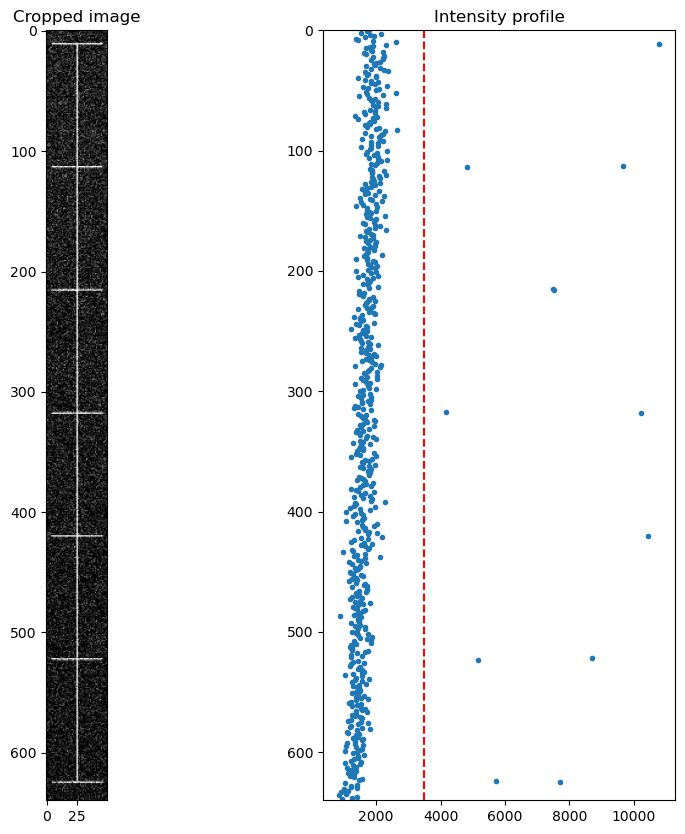

In [14]:
# Read the calibration images in grayscale [y, x]
img = cv.imread('PTV/Calibration_b.png', 0)
# img_b = cv.imread('PTV/Calibration_b.png', 0)

# Crop the images to show only the calibration pattern
roi = [30, 670, 200, 250] # [y1, y2, x1, x2]
img_a_crop = img[roi[0]:roi[1], roi[2]:roi[3]]

# Add up all pixels in the x-direction to get the intensity profile
profile = np.sum(img_a_crop, axis=1)


intensity_threshold = 3500

# Show the cropped images and profile side-by-side
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(img_a_crop, cmap='gray')
ax[0].set_title('Cropped image')
ax[1].plot(profile, np.arange(0, len(profile)), '.')
ax[1].set_title('Intensity profile')

# Plot a vertical line at y = 3500
ax[1].axvline(intensity_threshold, color='r', linestyle='--')

# Flip the profile axis to match the image
ax[1].invert_yaxis()
ax[1].set_ylim([len(profile), 0])

plt.show()

Pixel centres do not matter, is just half a pixel offset.

We kunnen nog Gaussians fitten!

In [15]:
# Set points below the threshold to zero
peak_mask = profile > intensity_threshold

# For each row...
peak_list_px = []; current_peak = []
for i in range(len(profile)):
    
    # Check whether the current row is above the threshold
    if profile[i] > intensity_threshold:
        
        # If so, append the row number to the list of peak indices
        current_peak.append(i)
    else:
        
        # If not, check whether this is the end of a peak
        if len(current_peak) > 0:
            
            # Calculate an average peak coordinate, weighted by the intensity 
            peak_list_px.append(np.dot(profile[current_peak], current_peak) /
                                np.sum(profile[current_peak]))
            
            # Reset the current peak list
            current_peak = []
            
# Convert the list of peak indices to a numpy array
peak_list_px = np.array(peak_list_px)

In [16]:
def weighted_avg_and_std(values, weights, mask_diagonal=True,
                         verbose=False, precision=6, units="m/px"):
    """
    Calculate the weighted average and standard deviation of a set of values.

    PARAMETERS:
        values (array-like): The values for which to calculate the weighted 
            average and standard deviation.
        weights (array-like): The weights corresponding to each value.
        mask_diagonal (bool): Whether to mask the diagonal of the
            distance matrix (default: True).
        verbose (bool): Whether to print the results (default: False).
        precision (int): The number of decimal places to round the results 
            to (default: 5).

    RETURNS:
        tuple: A tuple containing the weighted average and standard deviation.
    """

    # Mask the diagonal to avoid division by zero
    if mask_diagonal:
        mask = np.eye(values.shape[0], dtype=bool).__invert__()

    # Calculate the weighted average
    average = np.average(values[mask], weights=weights[mask])

    # Calculate the weighted variance and standard deviation
    variance = np.average((values[mask] - average) ** 2, weights=weights[mask])
    deviation = np.sqrt(variance)
    
    if verbose:
        print(f"The average resolution is {average:.{precision}f} {units},")
        print(f"with a standard deviation of {np.sqrt(variance):.{precision}f}"
              f" {units} ({100 * deviation / average:.{precision-2}} %).")

    # Output the average and standard deviation
    return average, deviation

In [17]:
calibration_distance = 0.5 # m

all_distances_px = (spatial.distance.cdist(peak_list_px.reshape(-1, 1),
                                           peak_list_px.reshape(-1, 1)))
peak_list_re = calibration_distance * np.arange(0, len(peak_list_px))

all_distances_re = (spatial.distance.cdist(peak_list_re.reshape(-1, 1),
                                           peak_list_re.reshape(-1, 1)))

with np.errstate(divide='ignore', invalid='ignore'):
    # Calculate the resolution of the image in pixels per unit length
    resolution = all_distances_re / all_distances_px
    
resolution_avg, resolution_std = weighted_avg_and_std(resolution, 
                                                   all_distances_px, verbose=True)

The average resolution is 0.004889 m/px,
with a standard deviation of 0.000002 m/px (0.03434 %).
